In [ ]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径


In [ ]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\简单插值\\原始数据-时间戳.xlsx'
df_sheet = pd.read_excel(excel_path, sheet_name='Sheet2') 
print(df_sheet.info())
print(df_sheet.columns)


In [ ]:
# 定义输入输出参数
input_term = ['富氧流量', '冷风流量', '热风压力', '热风温度', '鼓风湿度', '设定喷煤量', '上小时喷煤量']
output_term = ['铁口1温度', 'SI']
time_term= '时间戳'


In [ ]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_process = df_sheet.copy()
# 定义一个函数，用前后两个值的差值按照距离进行加权替换异常值
def replace_outliers_with_weighted_diff(x, y):
    # 计算列的中位数
    median_value = y.median()
    # 检测异常值的索引
    outliers_index = (y - median_value).abs() > 1.5 * y.std()  # 使用标准差作为阈值
    
    # 遍历异常值的索引
    for idx in outliers_index[outliers_index].index:
        # 获取异常值前一个和后一个值的索引
        prev_idx = idx - 1 if idx - 1 >= 0 else idx
        next_idx = idx + 1 if idx + 1 < len(y) else idx
        # 计算当前 x 与前后两个 x 的距离
        dist_prev = abs(x[idx] - x[prev_idx])
        dist_next = abs(x[next_idx] - x[idx])
        total_dist = dist_prev + dist_next
        # 计算权重
        weight_prev = dist_next / total_dist
        weight_next = dist_prev / total_dist
        # 计算前后两个值的差值
        diff = y[next_idx] - y[prev_idx]
        # 根据权重进行插值
        interpolated_value = y[prev_idx] + weight_prev * diff
        # 用插值结果替代异常值
        y[idx] = interpolated_value




# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# 对指定列应用替代异常值的函数
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[0]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[1]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[2]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[4]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[5]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[6]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[output_term[0]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[output_term[1]])

plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet[column].values,df_sheet_process[column].values,column)




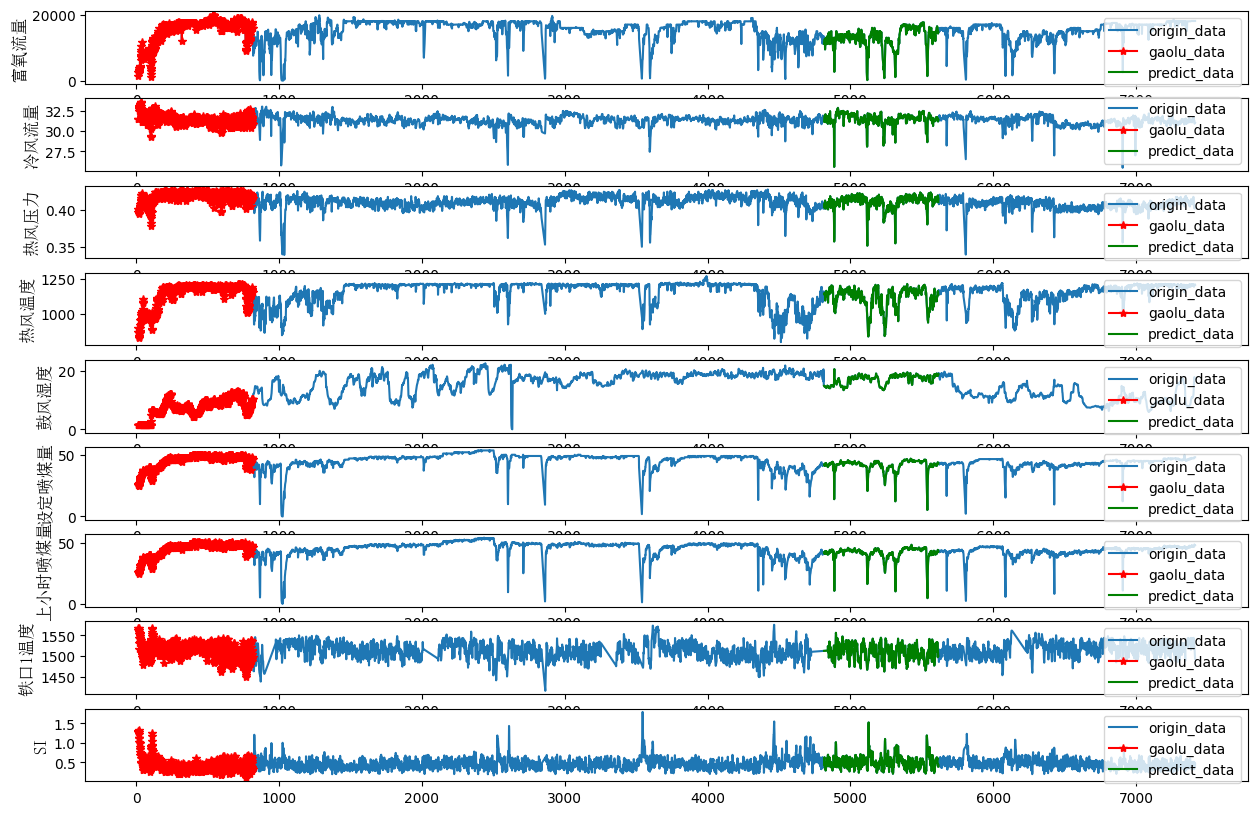

In [162]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-', label='origin_data')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'r*-', label='gaolu_data')
    plt.plot(data_x[index_predict],data_y[index_predict],'g-', label='predict_data')
    plt.legend()
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签



length1 = 800
start1 = 0
length2 = 800
start2 = 4800


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet_process[column].values,column,index_predict,index_gaolu)


In [163]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet_process[input_term[0]].values,
    input_term[1]:   df_sheet_process[input_term[1]].values,
    input_term[2]:   df_sheet_process[input_term[2]].values,
    input_term[3]:   df_sheet_process[input_term[3]].values,
    input_term[4]:   df_sheet_process[input_term[4]].values,
    input_term[5]:   df_sheet_process[input_term[5]].values,
    input_term[6]:   df_sheet_process[input_term[6]].values,
    output_term[0]:  df_sheet_process[output_term[0]].values,
    output_term[1]:  df_sheet_process[output_term[1]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [164]:
# 标定归一化前后数据
data_point = np.array([1500]).reshape(-1, 1)
data1 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[0]].inverse_transform(data_point).flatten()

data_point = np.array([1510]).reshape(-1, 1)
data3 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[0]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_temp = (data3-data1)/(data4-data2)
print('每摄氏度的输出差：',d_temp)



data_point = np.array([0.50]).reshape(-1, 1)
data1 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[1]].inverse_transform(data_point).flatten()

data_point = np.array([0.60]).reshape(-1, 1)
data3 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[1]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_yuansu = (data3-data1)/(data4-data2)
print('每0.01浓度的输出差：',(data3-data1))


[0.05471948]
[1500.]
[0.18042565]
[1510.]
每摄氏度的输出差： [0.01257062]
[-0.52854026]
[0.5]
[-0.40998065]
[0.6]
每0.01浓度的输出差： [0.11855962]


In [165]:
isShuffle = True
# isShuffle = False


In [166]:
# 组合训练数据--拆分训练、测试集
train_size = 0.7
val_size = 0.15
test_size = 0.15
def make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,y1_data,y2_data):
    u1_data = u1_data
    u2_data = u2_data
    u3_data = u3_data
    u4_data = u4_data
    u5_data = u5_data
    u6_data = u6_data
    u7_data = u7_data

    u1_data_1 = np.roll(u1_data, 1)
    u2_data_1 = np.roll(u2_data, 1)
    u3_data_1 = np.roll(u3_data, 1)
    u4_data_1 = np.roll(u4_data, 1)
    u5_data_1 = np.roll(u5_data, 1)
    u6_data_1 = np.roll(u6_data, 1)
    u7_data_1 = np.roll(u7_data, 1)

    y1_data = y1_data
    y2_data = y2_data

    X = np.column_stack((   u1_data  [1:-1], u2_data  [1:-1], u3_data  [1:-1], u4_data  [1:-1], u5_data  [1:-1], u6_data  [1:-1], u7_data  [1:-1],
                            u1_data_1[1:-1], u2_data_1[1:-1], u3_data_1[1:-1], u4_data_1[1:-1], u5_data_1[1:-1], u6_data_1[1:-1], u7_data_1[1:-1],
                            y1_data  [1:-1], y2_data  [1:-1], y1_data[2:], y2_data[2:])
                        )
    y = np.column_stack((y1_data[2:],y2_data[2:]))

    # 使用 reshape 转换形状(457, 10) (457, 2)--->(457, 1, 10) (457, 1, 2)
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
    y_reshaped = y.reshape((y.shape[0], 1, y.shape[1]))
    print('总数据数量：',y.shape)




    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)




    y_train = y_train.reshape((y_train.shape[0],y_train.shape[2]))
    y_val = y_val.reshape((y_val.shape[0],y_val.shape[2]))
    y_test = y_test.reshape((y_test.shape[0],y_test.shape[2]))
    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [167]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]][index_gaolu]
u2_data = normalized_data_dict[input_term[1]][index_gaolu]
u3_data = normalized_data_dict[input_term[2]][index_gaolu]
u4_data = normalized_data_dict[input_term[3]][index_gaolu]
u5_data = normalized_data_dict[input_term[4]][index_gaolu]
u6_data = normalized_data_dict[input_term[5]][index_gaolu]
u7_data = normalized_data_dict[input_term[6]][index_gaolu]
y1_data = normalized_data_dict[output_term[0]][index_gaolu]
y2_data = normalized_data_dict[output_term[1]][index_gaolu]
num_samples = y1_data.shape[0]
print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,y1_data,y2_data)

# 预测模型列数据
u1_data = normalized_data_dict[input_term[0]][index_predict]
u2_data = normalized_data_dict[input_term[1]][index_predict]
u3_data = normalized_data_dict[input_term[2]][index_predict]
u4_data = normalized_data_dict[input_term[3]][index_predict]
u5_data = normalized_data_dict[input_term[4]][index_predict]
u6_data = normalized_data_dict[input_term[5]][index_predict]
u7_data = normalized_data_dict[input_term[6]][index_predict]
y1_data = normalized_data_dict[output_term[0]][index_predict]
y2_data = normalized_data_dict[output_term[1]][index_predict]
num_samples = y1_data.shape[0]
print('预测模型数据')
X_predict_train, X_predict_val, X_predict_test,\
y_predict_train, y_predict_val, y_predict_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,y1_data,y2_data)

all_data_X_gaolu = np.concatenate((X_gaolu_train, X_gaolu_val, X_gaolu_test),axis=0)  
all_data_y_gaolu = np.concatenate((y_gaolu_train, y_gaolu_val, y_gaolu_test),axis=0)  
print(all_data_X_gaolu.shape)
print(all_data_y_gaolu.shape)
all_data_X_predict = np.concatenate((X_predict_train, X_predict_val, X_predict_test),axis=0)  
all_data_y_predict = np.concatenate((y_predict_train, y_predict_val, y_predict_test),axis=0)  
print(all_data_X_predict.shape)
print(all_data_y_predict.shape)


高炉模型数据
总数据数量： (799, 2)
训练数量： (559, 1, 18) (559, 2)
验证数量： (120, 1, 18) (120, 2)
测试数量： (120, 1, 18) (120, 2)
预测模型数据
总数据数量： (799, 2)
训练数量： (559, 1, 18) (559, 2)
验证数量： (120, 1, 18) (120, 2)
测试数量： (120, 1, 18) (120, 2)
(799, 1, 18)
(799, 2)
(799, 1, 18)
(799, 2)


In [168]:
import numpy as np

def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

def custom_kmeans(X, n_clusters, max_iter=700):
    # 随机初始化聚类中心
    centroids_indices = np.random.choice(X.shape[0], size=n_clusters, replace=False)
    print(centroids_indices)
    centroids = X[centroids_indices]
    
    for _ in range(max_iter):
        # 计算每个样本到聚类中心的余弦相似度
        similarities = np.array([[cosine_similarity(x, centroid) for centroid in centroids] for x in X])
        
        # 分配样本到与其余弦相似度大于阈值的最近的聚类中心所属的簇
        labels = np.argmax(similarities, axis=1)
        
        # 更新聚类中心为每个簇的均值
        new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(n_clusters)])
        
        # 检查聚类中心是否收敛
        if np.allclose(centroids, new_centroids):
            break
        
        centroids = new_centroids
    
    return labels, centroids

# 使用示例
# 生成示例数据
np.random.seed(0)
X = all_data_X_gaolu.reshape(all_data_X_gaolu.shape[0], 18)

# 指定聚类数量
n_clusters = 300

# 执行自定义的余弦相似度聚类
labels, centroids = custom_kmeans(X, n_clusters)

# 打印聚类结果和聚类中心
print("Labels:", labels)
print("Centroids:", centroids[0])
# 统计每个类别的数量
cluster_counts = np.bincount(labels)
print(cluster_counts)


[399 533 345  40 641 434 235 604 740 535  14 239 503 706  27  55 255 200
 162 704 642 113 561 520 676 303 156 479 261 215 519 653  85 529 266  31
 789 436 231 422 577 795 202 640 367 435 425 632 103 687 578 569 210  75
 612 457 374 644 634 310 716   8 572 735 145 730 452 142 392 608 382 386
   1 380 497  79 702 715 725 628 250 249 389 689 385 299 651 418 484 294
 358 122 691 424 603 757 710 609 440 251 454 331 415 272  18 230 409 302
 491 420 580  50 694 767 493 593 258  39 390 404 661 175  10 649  68 474
 241 724 447 204 346 769   2 791 247 150 196 253 738 397 481 727 790 267
 618 416 283  71  49 243 576 116  37 279  48 193 460 542 700 242 172  76
  64 636  52 337 439 458 517 252  34 546 278 646 118  12 157 236 312 553
 333 181 614  97 666 668 319 749 766 500 751 363 548 722 623 372 526  17
 320 518 788 761 511 648 531 733 451 776 170 187 720 222  45 585 352  62
  78 240 652 301 140 198 338 568 127 401 413 489 144 214 362 293  21 635
 571  35  81 159 441  77 408 513 306 109 263 796 10

In [170]:
X_gaolu_train = centroids[:,0:16].reshape(n_clusters,1,16)
y_gaolu_train = centroids[:,16:18].reshape(n_clusters,2)
X_gaolu_val = X_gaolu_val[:,:,0:16].reshape(X_gaolu_val.shape[0],1,16)
X_gaolu_test = X_gaolu_test[:,:,0:16].reshape(X_gaolu_test.shape[0],1,16)


In [171]:
# 定义LSTM模型
import torch
import torch.nn as nn
import torch.optim as optim

class MyRNNModel(torch.nn.Module):
    def __init__(self,features_size,hidden_size,isbidirectional):
        super(MyRNNModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=features_size,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=isbidirectional
        )
        if isbidirectional:
            self.fc = nn.Linear(2 * hidden_size, 2)
        else:
            self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        last_lstm_output = lstm_out[:, -1, :]
        # print(last_lstm_output)
        output = self.fc(last_lstm_output)
        
        return output

    def custom_loss(self, y_true, y_pred):
        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse



    def my_fit(self, 
                X_train, y_train, 
                X_val, y_val, 
                train_loss_list,val_loss_list,
                epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)


        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_train_loss = epoch_loss / (len(X_train) / batch_size)
            # 验证集评估
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for i in range(0, len(X_val), batch_size):
                    x_batch_val = torch.tensor(X_val[i:i+batch_size], dtype=torch.float32)
                    y_batch_val = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32)

                    y_pred_val = self(x_batch_val)
                    val_loss += self.custom_loss(y_batch_val, y_pred_val).item()

                average_epoch_val_loss = val_loss / (len(X_val) / batch_size)

            print(f'第 {epoch + 1}/{epochs} 轮, 训练误差: {average_epoch_train_loss:.4f}, 验证误差: {average_epoch_val_loss:.4f}', end='\r')
            train_loss_list.append(average_epoch_train_loss)
            val_loss_list.append(average_epoch_val_loss)

        return train_loss_list,val_loss_list
    def my_fit2(self, X_train, y_train):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        x_batch = torch.tensor(X_train, dtype=torch.float32)
        y_batch = torch.tensor(y_train, dtype=torch.float32)
        optimizer.zero_grad()
        y_pred = self(x_batch)
        loss = self.custom_loss(y_batch, y_pred)
        loss.backward()
        optimizer.step()
        return loss.item()
    
    

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred[:,0].detach().numpy(),y_pred[:,1].detach().numpy()


In [182]:
epoch_once_time = 200


In [183]:
# 建立高炉模型实例
features_size = 16
hidden_size = 16
# 设置随机种子
torch.manual_seed(0)
model_gaolu = MyRNNModel(features_size = features_size, 
                        hidden_size = hidden_size,
                        isbidirectional=True)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []


第 200/200 轮, 训练误差: 0.0154, 验证误差: 0.0181
epoch_sum: 200


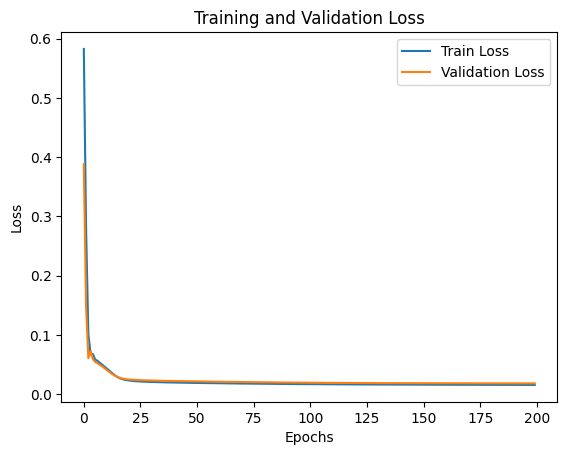

In [184]:
# 高炉模型训练
epoch_once = epoch_once_time
epoch_sum_gaolu = epoch_sum_gaolu + epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = model_gaolu.my_fit(X_gaolu_train, y_gaolu_train,
                                    X_gaolu_val, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=32,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)

# 绘制训练和验证损失曲线
plt.plot(gaolu_train_loss_list, label='Train Loss')
plt.plot(gaolu_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



RMSE:  铁口1温度: 7.4523 , SI: 0.0636 
MAPE:  铁口1温度: 0.3990% , SI: 14.5532%
MRE :  铁口1温度: 0.0040  , SI: 0.1455 
per :  铁口1温度: 0.8083  , SI: 0.8917 


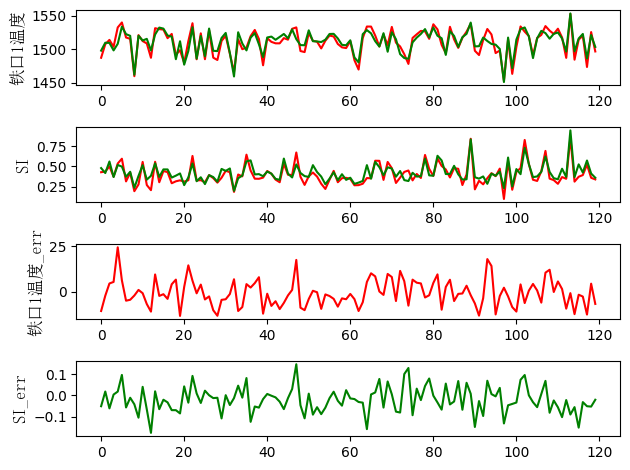

In [185]:
# 高炉模型预测
y_pred_0,y_pred_1  = model_gaolu.my_predict(X_gaolu_test)
# 计算 RMSE、MRE
y_test = y_gaolu_test
# y_test = y_test[:70]
# y_pred_0 = y_pred_0[:70]
# y_pred_1 = y_pred_1[:70]




y_test_0 = scalers[output_term[0]].inverse_transform((y_test[:, 0]).reshape(-1, 1)).flatten()
y_test_1 = scalers[output_term[1]].inverse_transform((y_test[:, 1]).reshape(-1, 1)).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_inverse_transform = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))
rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_1_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))
mre_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1))


mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
mape_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1)) * 100

percent0 = np.sum(np.fabs(y_test_0 - y_pred_0_inverse_transform) < 10)/len(y_test_0)
percent1 = np.sum(np.fabs(y_test_1 - y_pred_1_inverse_transform) < 0.1)/len(y_test_1)
# 打印结果

print(f"RMSE:  {output_term[0]}: {rmse_0:.4f} , {output_term[1]}: {rmse_1:.4f} ")
print(f"MAPE:  {output_term[0]}: {mape_0:.4f}% , {output_term[1]}: {mape_1:.4f}%")
print(f"MRE :  {output_term[0]}: { mre_0:.4f}  , {output_term[1]}: { mre_1:.4f} ")
print(f"per :  {output_term[0]}: { percent0:.4f}  , {output_term[1]}: { percent1:.4f} ")

# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


output0 = y_test_0 - y_pred_0_inverse_transform
output1 = y_test_1 - y_pred_1_inverse_transform

# print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
# print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")


plt.subplot(4, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 2)
plt.plot(y_test_1,'r')
plt.plot(y_pred_1_inverse_transform,'g')
plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
#

plt.subplot(4, 1, 3)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 4)
plt.plot(output1,'g-')
plt.ylabel(output_term[1]+'_err', fontproperties=font)  # 使用中文标签


plt.tight_layout()
plt.show()



In [186]:
import numpy as np

def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

def custom_kmeans(X, n_clusters, max_iter=700):
    # 随机初始化聚类中心
    centroids_indices = np.random.choice(X.shape[0], size=n_clusters, replace=False)
    print(centroids_indices)
    centroids = X[centroids_indices]
    
    for _ in range(max_iter):
        # 计算每个样本到聚类中心的余弦相似度
        similarities = np.array([[cosine_similarity(x, centroid) for centroid in centroids] for x in X])
        
        # 分配样本到与其余弦相似度大于阈值的最近的聚类中心所属的簇
        labels = np.argmax(similarities, axis=1)
        
        # 更新聚类中心为每个簇的均值
        new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(n_clusters)])
        
        # 检查聚类中心是否收敛
        if np.allclose(centroids, new_centroids):
            break
        
        centroids = new_centroids
    
    return labels, centroids

# 使用示例
# 生成示例数据
np.random.seed(0)
X = all_data_X_predict.reshape(all_data_X_predict.shape[0], 18)

# 指定聚类数量
n_clusters = 300

# 执行自定义的余弦相似度聚类
labels, centroids = custom_kmeans(X, n_clusters)

# 打印聚类结果和聚类中心
print("Labels:", labels)
print("Centroids:", centroids[0])
# 统计每个类别的数量
cluster_counts = np.bincount(labels)
print(cluster_counts)


[399 533 345  40 641 434 235 604 740 535  14 239 503 706  27  55 255 200
 162 704 642 113 561 520 676 303 156 479 261 215 519 653  85 529 266  31
 789 436 231 422 577 795 202 640 367 435 425 632 103 687 578 569 210  75
 612 457 374 644 634 310 716   8 572 735 145 730 452 142 392 608 382 386
   1 380 497  79 702 715 725 628 250 249 389 689 385 299 651 418 484 294
 358 122 691 424 603 757 710 609 440 251 454 331 415 272  18 230 409 302
 491 420 580  50 694 767 493 593 258  39 390 404 661 175  10 649  68 474
 241 724 447 204 346 769   2 791 247 150 196 253 738 397 481 727 790 267
 618 416 283  71  49 243 576 116  37 279  48 193 460 542 700 242 172  76
  64 636  52 337 439 458 517 252  34 546 278 646 118  12 157 236 312 553
 333 181 614  97 666 668 319 749 766 500 751 363 548 722 623 372 526  17
 320 518 788 761 511 648 531 733 451 776 170 187 720 222  45 585 352  62
  78 240 652 301 140 198 338 568 127 401 413 489 144 214 362 293  21 635
 571  35  81 159 441  77 408 513 306 109 263 796 10

In [187]:
X_predict_train = centroids[:,0:16].reshape(n_clusters,1,16)
y_predict_train = centroids[:,16:18].reshape(n_clusters,2)
X_predict_val = X_predict_val[:,:,0:16].reshape(X_predict_val.shape[0],1,16)
X_predict_test = X_predict_test[:,:,0:16].reshape(X_predict_test.shape[0],1,16)


In [188]:
# 创建预测模型实例
features_size = 16
hidden_size_predict = 16
# 设置随机种子
torch.manual_seed(0)
model = MyRNNModel(features_size = features_size, 
                    hidden_size = hidden_size_predict,
                    isbidirectional=True)
epoch_sum_predict = 0
predict_train_loss_list = []
predict_val_loss_list = []


第 200/200 轮, 训练误差: 0.0188, 验证误差: 0.0262
epoch_sum: 0


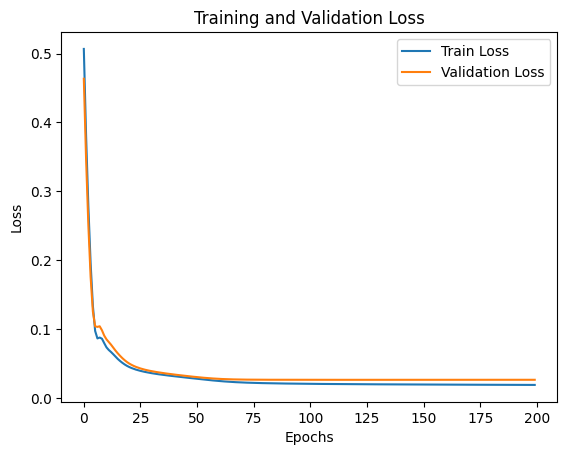

In [189]:
# 预测模型训练
epoch_once = epoch_once_time
epoch_sum = epoch_sum_predict + epoch_once
predict_train_loss_list, predict_val_loss_list = model.my_fit(X_predict_train, y_predict_train,
                                    X_predict_val, y_predict_val, 
                                    predict_train_loss_list, predict_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=64,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_predict)


# 绘制训练和验证损失曲线
plt.plot(predict_train_loss_list, label='Train Loss')
plt.plot(predict_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RMSE:  铁口1温度: 9.6046 , SI: 0.0754 
MAPE:  铁口1温度: 0.4990% , SI: 12.9714%
MRE :  铁口1温度: 0.0050  , SI: 0.1297 
per :  铁口1温度: 0.7250  , SI: 0.8250 


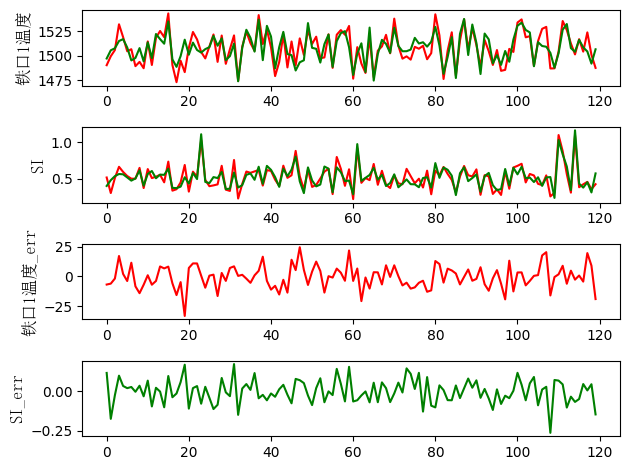

In [190]:
# 预测模型预测
y_pred_0,y_pred_1  = model.my_predict(X_predict_test)

# 计算 RMSE、MRE
y_test = y_predict_test







y_test_0 = scalers[output_term[0]].inverse_transform((y_test[:, 0]).reshape(-1, 1)).flatten()
y_test_1 = scalers[output_term[1]].inverse_transform((y_test[:, 1]).reshape(-1, 1)).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_inverse_transform = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))
rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_1_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))
mre_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1))


mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
mape_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1)) * 100

percent0 = np.sum(np.fabs(y_test_0 - y_pred_0_inverse_transform) < 10)/len(y_test_0)
percent1 = np.sum(np.fabs(y_test_1 - y_pred_1_inverse_transform) < 0.1)/len(y_test_1)
# 打印结果

print(f"RMSE:  {output_term[0]}: {rmse_0:.4f} , {output_term[1]}: {rmse_1:.4f} ")
print(f"MAPE:  {output_term[0]}: {mape_0:.4f}% , {output_term[1]}: {mape_1:.4f}%")
print(f"MRE :  {output_term[0]}: { mre_0:.4f}  , {output_term[1]}: { mre_1:.4f} ")
print(f"per :  {output_term[0]}: { percent0:.4f}  , {output_term[1]}: { percent1:.4f} ")

# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


output0 = y_test_0 - y_pred_0_inverse_transform
output1 = y_test_1 - y_pred_1_inverse_transform

# print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
# print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")


plt.subplot(4, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 2)
plt.plot(y_test_1,'r')
plt.plot(y_pred_1_inverse_transform,'g')
plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
#

plt.subplot(4, 1, 3)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 4)
plt.plot(output1,'g-')
plt.ylabel(output_term[1]+'_err', fontproperties=font)  # 使用中文标签


plt.tight_layout()
plt.show()



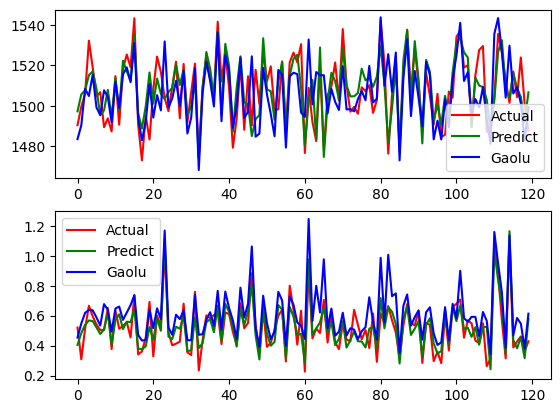

In [191]:
y_test = y_predict_test
y_test_0 = scalers[output_term[0]].inverse_transform(y_predict_test[:,0].reshape(-1, 1)).flatten()
y_test_1 = scalers[output_term[1]].inverse_transform(y_predict_test[:,1].reshape(-1, 1)).flatten()
y_pred_0,y_pred_1  = model.my_predict(X_predict_test)
y_pred_0_predict = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_predict = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

y_pred_0,y_pred_1  = model_gaolu.my_predict(X_predict_test)
y_pred_0_gaolu = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_gaolu = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

plt.subplot(2, 1, 1)
plt.plot(y_test_0, 'r-', label='Actual')
plt.plot(y_pred_0_predict, 'g-', label='Predict')
plt.plot(y_pred_0_gaolu, 'b', label='Gaolu')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y_test_1, 'r-', label='Actual')
plt.plot(y_pred_1_predict, 'g-', label='Predict')
plt.plot(y_pred_1_gaolu, 'b', label='Gaolu')
plt.legend()

